In [44]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

In [75]:
stats.norm.ppf(0.99)

2.3263478740408408

In [107]:
from scipy.special import binom
import time

def generate_uniform(N):
    return np.random.uniform(-1,1,N)

def generate_3uniform(N):
    return np.random.uniform(-1,1,N) + np.random.uniform(-1,1,N) + np.random.uniform(-1,1,N)

def generate_cauchy(N):
    return np.random.standard_cauchy(N)

def generate_normal(N):
    return np.random.normal(0, 1, int(N))

def plot_intervals(type_interval, func_generate, mean, q=0.95, p=0.5, mode='default'):
    # Uniform - student 
    N = 10
    n_values = []
    real_p = []
    all_l, all_r = [], []
    time_spent = []
    z_critical = stats.norm.ppf((1+q)/2)
    std_dev = 1
    if func_generate == generate_uniform:
        std_dev = 1/3

    x1_not_included, xn_not_included = 1, 1 
    
    for i in tqdm(range(6)):
        standard_error = std_dev / np.sqrt(N)
        count_exp_in_interval = []
        cur_l, cur_r = [], []
        N = int(N)
        
        start_time = time.time()
        
        for j in range(10000):
            data = func_generate(N)

            if mode == 'robust_check':
                data = np.append(data, 100.0)
            
            mean_cur = np.mean(data)
            a = min(data)
            b = max(data)
            
            if type_interval == 'normal':
                l, r = (mean_cur - z_critical * standard_error, mean_cur + z_critical * standard_error)
            elif type_interval == 'student':
                t_value = stats.t.ppf((1 + q) / 2, int(N) - 1) 
                l, r = (mean_cur - t_value * standard_error, mean_cur + t_value * standard_error)
            elif type_interval == 'hora-hora':
                d_value = np.sqrt(-np.log((1-q)/2)/2*int(N)) - 1/(6*int(N))
                if mode == 'robust_check':
                    sorted_data = np.sort(data)
                    a = sorted_data[1]   
                    b = sorted_data[-2]   
                l, r = (mean_cur - d_value * (b - a), mean_cur + d_value * (b - a))    
            elif type_interval == 'jackknife':
                cur_means = []
                data_original = data
                for k in range(int(N)):
                    data = np.delete(data_original, k)
                    cur_means.append(np.mean(data))
                jackknife_mean = np.mean(cur_means)
                jackknife_var = (int(N) - 1) * np.mean((cur_means - jackknife_mean) ** 2)
                l, r = jackknife_mean - z_critical * np.sqrt(jackknife_var), jackknife_mean + z_critical * np.sqrt(jackknife_var)
            elif type_interval == 'bootstrap':
                bootstrap_samples = []
                data_original = data
                for _ in range(100):
                    data = np.random.choice(data, int(N), replace=True)
                    bootstrap_samples.append(np.mean(data))
                bootstrap_mean = np.mean(bootstrap_samples)
                l, r = np.percentile(bootstrap_samples, [2.5, 97.5])
            elif type_interval == 'median_approximation':
                l, r = (N*p - np.sqrt(N*p*(1-p)) * z_critical, N*p + np.sqrt(N*p*(1-p)) * z_critical)
                data.sort()
                l, r = (data[max(0, math.floor(l))], data[min(math.ceil(r), N-1)])
            elif type_interval == 'median_analytical':
                data.sort()
                m1 = 0
                cur_sum = 0
                while cur_sum <= (1-q)/2 and m1 <= N:
                    cur_sum += binom(N, m1) * p**m1 * (1-p)**(N-m1)
                    m1 += 1
                m1 -= 1
                m2 = N
                cur_sum = 0
                while cur_sum <= (1-q)/2 and m2 >= 0:
                    cur_sum += binom(N, m2) * p**m2 * (1-p)**(N-m2)
                    m2 -= 1
                m2 += 1
                l, r = (data[m1-1], data[m2-1])
        
            if l <= mean and mean <= r:
                count_exp_in_interval.append(1)
            else:
                count_exp_in_interval.append(0)
    
            cur_l.append(l)
            cur_r.append(r)

            if data[0] <= l:
                x1_not_included = N
            if data[N-1] >= r:
                xn_not_included = N
            
            if type_interval == 'median_analytical':
                break

        end_time = time.time()
        time_spent.append(end_time - start_time)
        
        n_values.append(N)
        real_p.append(np.mean(count_exp_in_interval))
        all_l.append(np.mean(cur_l))
        all_r.append(np.mean(cur_r))
        if i % 2 == 0:
            N *= 5
        else:
            N *= 2
        
    plt.plot(n_values, real_p, marker='o')
    if x1_not_included > 1:
        plt.axvline(x1_not_included, color='red', linestyle='--', label='x1 not included')
    if xn_not_included > 1:
        plt.axvline(xn_not_included, color='green', linestyle='--', label='xn not included')
    plt.legend()
    plt.xscale('log')
    plt.grid(True) 
    plt.title(func_generate.__name__.split('_')[1])
    plt.show()

    if type_interval == 'median_analytical' or type_interval == 'median_approximation':
        return [n_values, all_l, all_r, time_spent]
    return [n_values, all_l, all_r]

In [78]:
def plot_intervals_on_one_plot(n_values, l_uni, l_3uni, l_norm, r_uni, r_3uni, r_norm):
    plt.plot(n_values, l_uni, marker='o', label='uniform')
    plt.plot(n_values, l_3uni, marker='o', label='sum of 3 uniform')
    plt.plot(n_values, l_norm, marker='o', label = 'normal')
    plt.xscale('log')
    plt.legend()
    plt.title('left border')
    plt.grid(True) 
    plt.show()

    plt.plot(n_values, r_uni, marker='o', label='uniform')
    plt.plot(n_values, r_3uni, marker='o', label='sum of 3 uniform')
    plt.plot(n_values, r_norm, marker='o', label = 'normal')
    plt.xscale('log')
    plt.legend()
    plt.title('right border')
    plt.grid(True) 
    plt.show()

In [79]:
def plot_time_on_one_plot(n_values, time_approx, time_analytical, dist):
    plt.plot(n_values, time_approx, marker='o', label='approximate')
    plt.plot(n_values, time_analytical, marker='o', label='analytical')
    plt.xscale('log')
    plt.legend()
    plt.title(dist)
    plt.grid(True) 
    plt.show()

# 1

In [22]:
def get_median(data):
    median = np.median(data)
    z_critical = stats.norm.ppf(0.975)
    standard_error = np.std(data, ddof=1) / np.sqrt(len(data))
    p = 0.5
    l, r = (median - z_critical * standard_error, median + z_critical * standard_error)
    return [median, l, r]

In [23]:
N = 10000
result = pd.DataFrame([get_median(generate_uniform(N)), 
                       get_median(generate_3uniform(N)), 
                       get_median(generate_normal(N))], index=['uniform', '3uniform', 'normal'], columns=['median', 'l', 'r'])
result.head()

,median,l,r
uniform,-0.004829,-0.016160,0.006503
3uniform,0.005844,-0.013736,0.025424
normal,-0.018699,-0.038337,0.000940


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


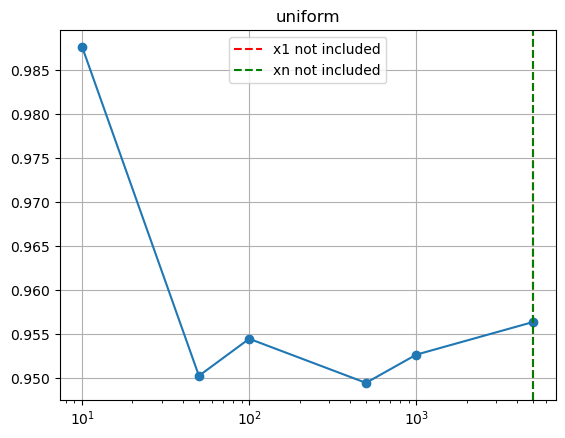

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.01s/it]


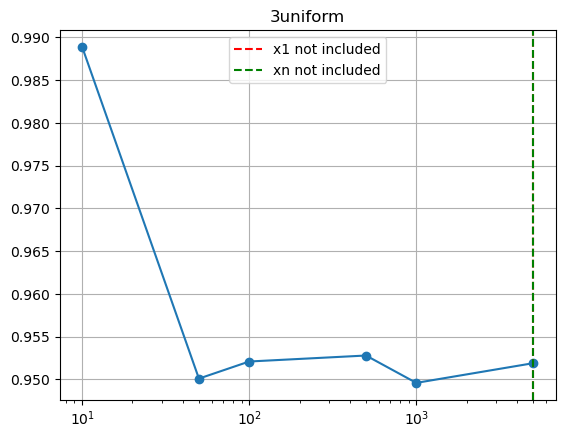

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.83s/it]


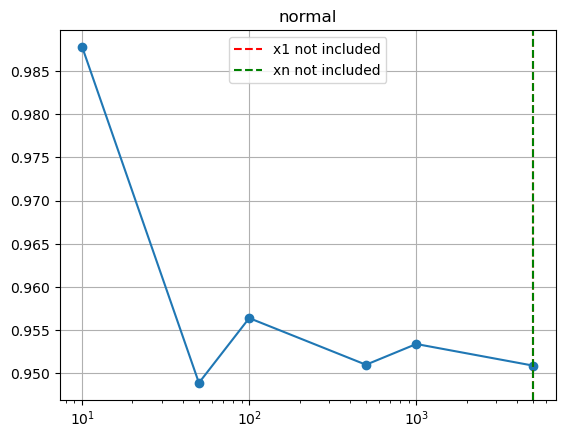

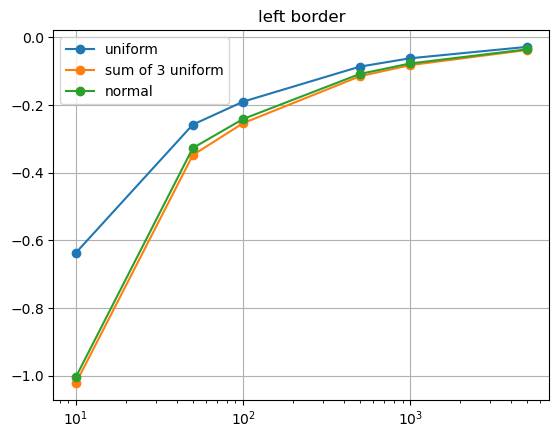

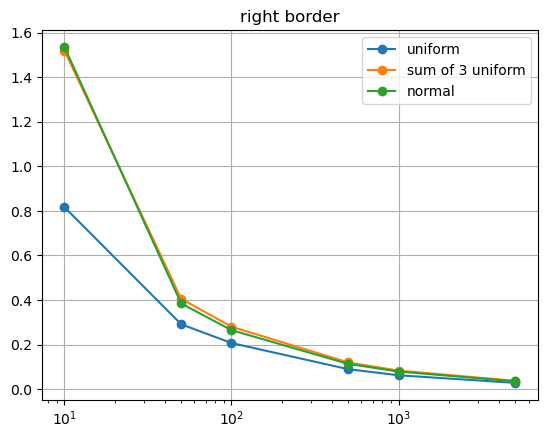

In [108]:
plot_args_l, plot_args_r = [], []
plot_time_approx = []
for dist in [generate_uniform, generate_3uniform, generate_normal]:
    n_values, l_cur, r_cur, time_spent = plot_intervals('median_approximation', dist, 0)
    plot_args_l.append(l_cur)
    plot_args_r.append(r_cur)
    plot_time_approx.append(time_spent)
plot_intervals_on_one_plot(n_values, *plot_args_l, *plot_args_r)

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_105/2377255490.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  cur_sum += binom(N, m1) * p**m1 * (1-p)**(N-m1)
/tmp/ipykernel_105/2377255490.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  cur_sum += binom(N, m2) * p**m2 * (1-p)**(N-m2)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 720.26it/s]


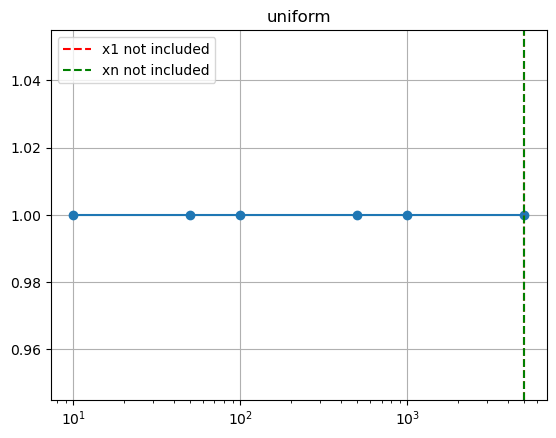

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 735.65it/s]


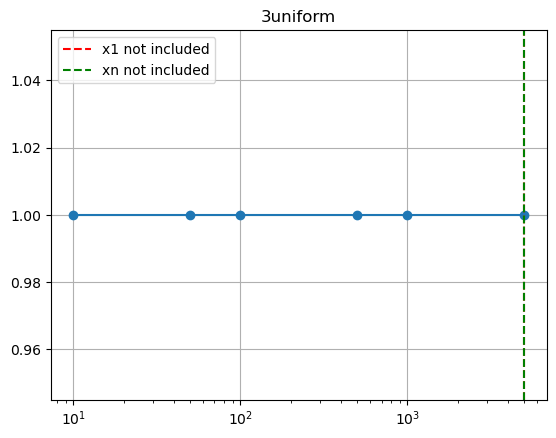

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 801.03it/s]


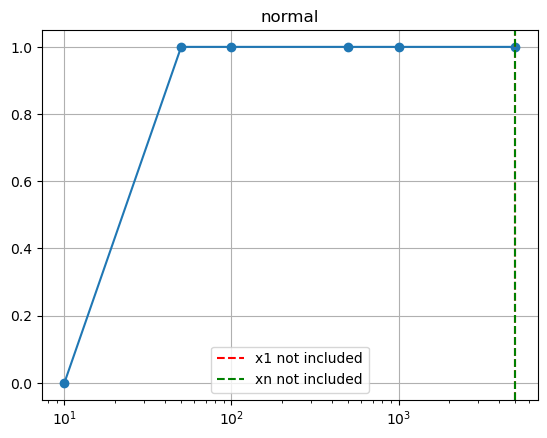

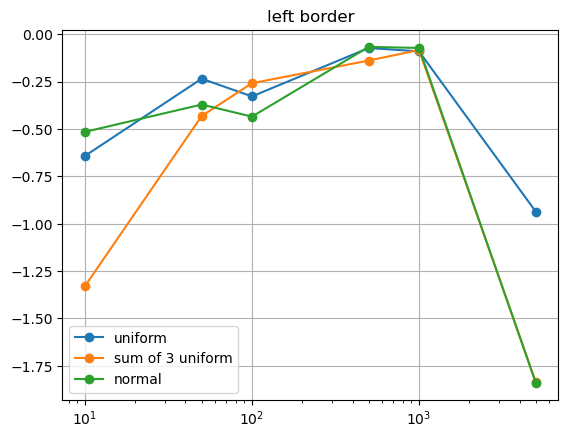

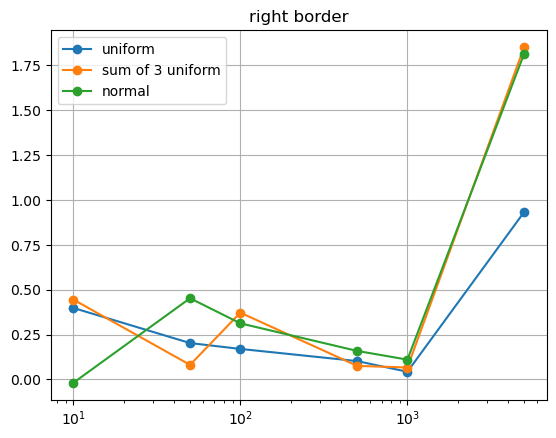

In [109]:
plot_args_l, plot_args_r = [], []
plot_time_analytical = []
for dist in [generate_uniform, generate_3uniform, generate_normal]:
    n_values, l_cur, r_cur, time_spent = plot_intervals('median_analytical', dist, 0)
    plot_args_l.append(l_cur)
    plot_args_r.append(r_cur)
    plot_time_analytical.append(time_spent)
plot_intervals_on_one_plot(n_values, *plot_args_l, *plot_args_r)

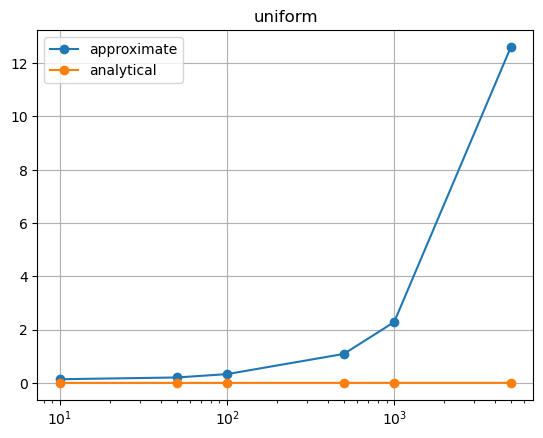

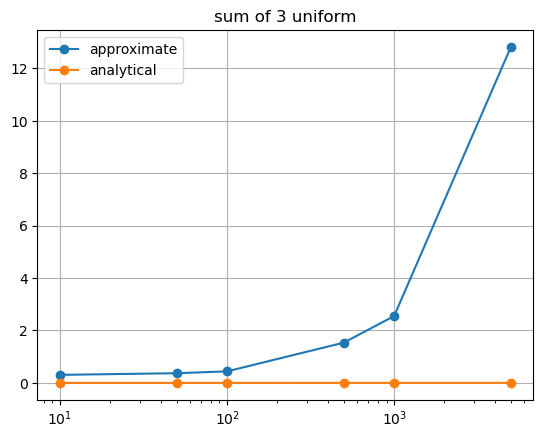

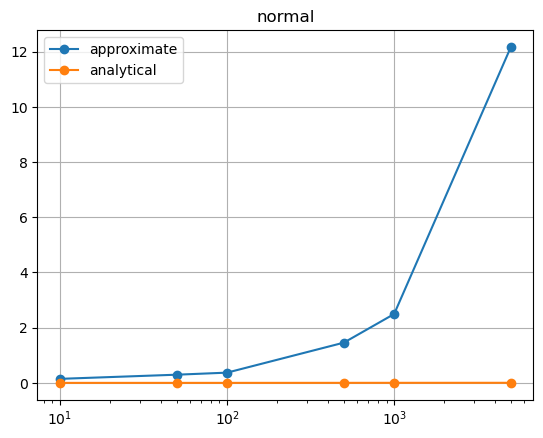

In [110]:
dists = ['uniform', 'sum of 3 uniform', 'normal']
for i in range(3):
    plot_time_on_one_plot(n_values, plot_time_approx[i], plot_time_analytical[i], dists[i])

# 2

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_105/2377255490.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  cur_sum += binom(N, m1) * p**m1 * (1-p)**(N-m1)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 466.22it/s]


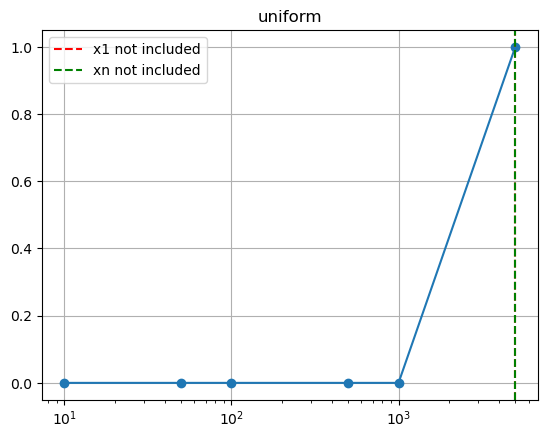

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 451.35it/s]


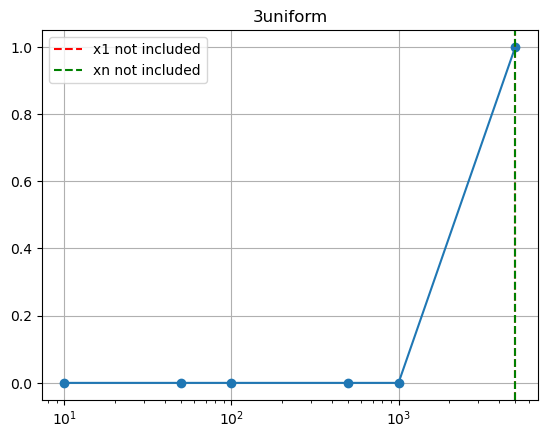

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 871.42it/s]


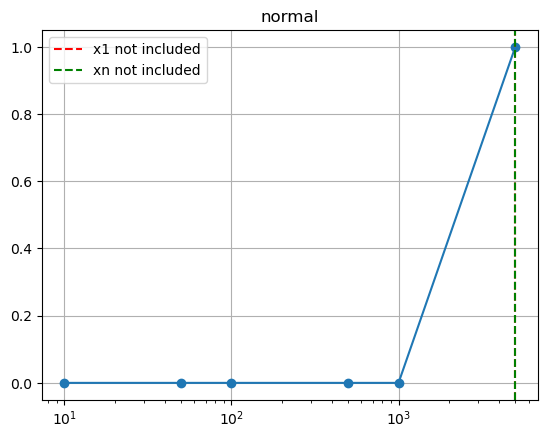

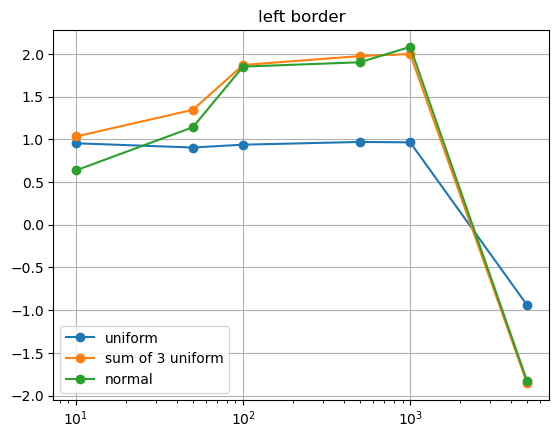

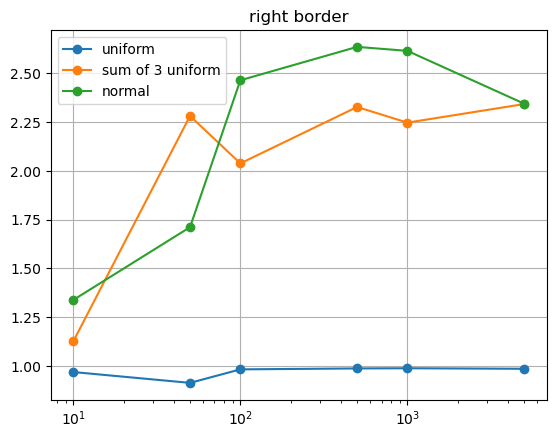

In [111]:
plot_args_l, plot_args_r = [], []
plot_time_approx = []
for dist in [generate_uniform, generate_3uniform, generate_normal]:
    n_values, l_cur, r_cur, time_spent = plot_intervals('median_analytical', dist, 0, p=0.99)
    plot_args_l.append(l_cur)
    plot_args_r.append(r_cur)
    plot_time_approx.append(time_spent)
plot_intervals_on_one_plot(n_values, *plot_args_l, *plot_args_r)

  0%|                                                                                             | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_105/2377255490.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  cur_sum += binom(N, m2) * p**m2 * (1-p)**(N-m2)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 883.54it/s]


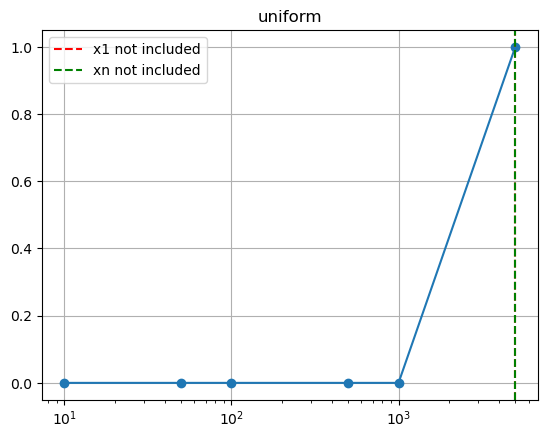

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1010.35it/s]


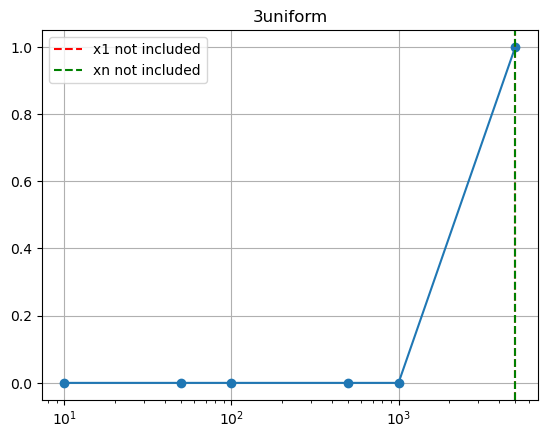

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 709.92it/s]


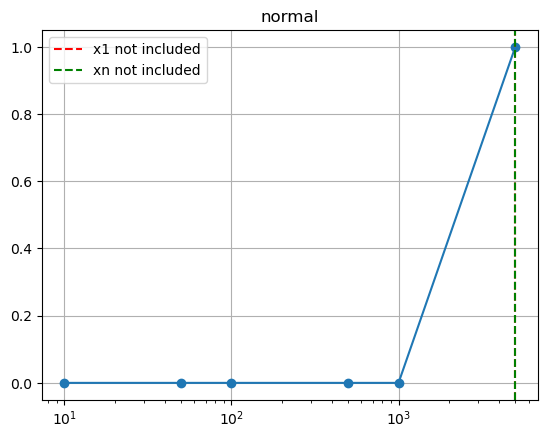

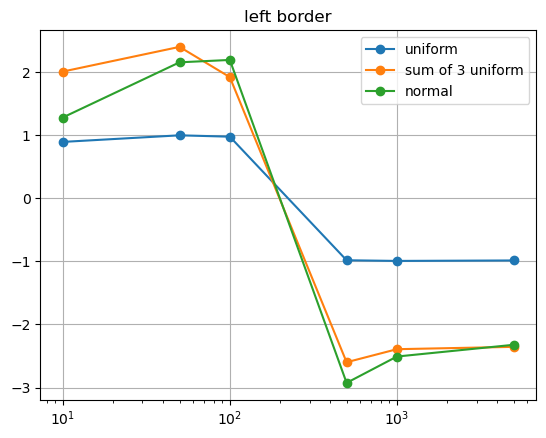

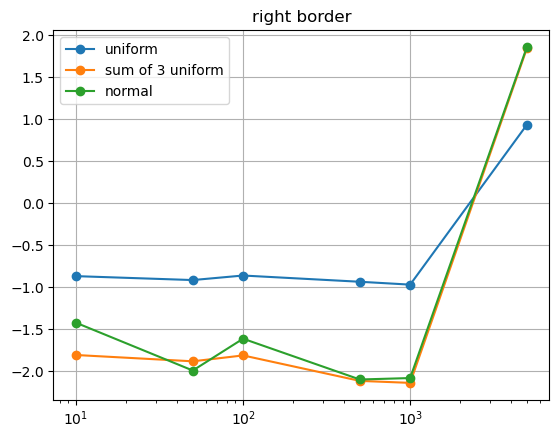

In [112]:
plot_args_l, plot_args_r = [], []
plot_time_approx = []
for dist in [generate_uniform, generate_3uniform, generate_normal]:
    n_values, l_cur, r_cur, time_spent = plot_intervals('median_analytical', dist, 0, p=0.01)
    plot_args_l.append(l_cur)
    plot_args_r.append(r_cur)
    plot_time_approx.append(time_spent)
plot_intervals_on_one_plot(n_values, *plot_args_l, *plot_args_r)